In [1]:
#importing necessary libraries, just run this part

import numpy as np
import matplotlib.pyplot as plt
from peakBasedFunctions import voigtNUniPeak
from stackingFunctions import widthNormLinStacker
from edibles.utils.functions import vac2air_ciddor
import os.path
from edibles.utils.ContinuumFitter import ContinuumFitter

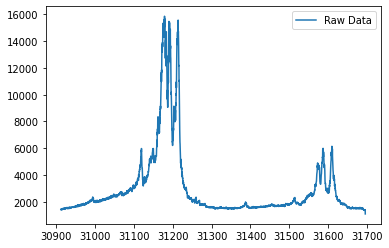

In [2]:
#loading raw data, change the file name for respective molecule and run this part

#put address for file
dataRaw = np.loadtxt('C:/Users/hkhan/edibles/edibles/data/Labdata/CRDS/PYRENE.DAT', skiprows = 1)
plt.plot(dataRaw[:, 0], dataRaw[:, 1], label = 'Raw Data')
plt.legend()

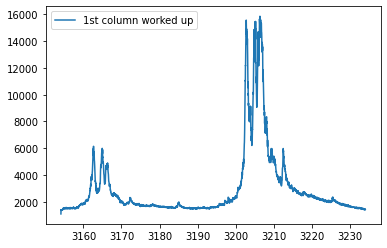

In [3]:
#workup of 1st column of data, change the option and run this part

#If in first column of file - wavelength is given in nm, set option = 0
#                           - wavelength is given in angstrom, set option = 1
#                           - wave number if given in 1/cm, set option = 2
option = 2

data = np.zeros(dataRaw.shape)

if option == 0:
    data[:, 0] = vac2air_ciddor(dataRaw[:, 0]*10.0)
elif option == 1:
    data[:, 0] = vac2air_ciddor(dataRaw[:, 0])
elif option == 2:
    data[:, 0] = vac2air_ciddor((1/dataRaw[:, 0])*1e8)
    
data[:, 1] = dataRaw[:, 1]
    
plt.plot(data[:, 0], data[:, 1], label = '1st column worked up')
plt.legend()

In [4]:
#run this part to select points to find continuum
#select points (in strict increasing wavelength order) by left clicking
#once done selecting, press centre mouse key to end selecting

CF1 = ContinuumFitter(data[:, 0], data[:, 1])
CS, contPoints  = CF1.SplineManualAnchor()

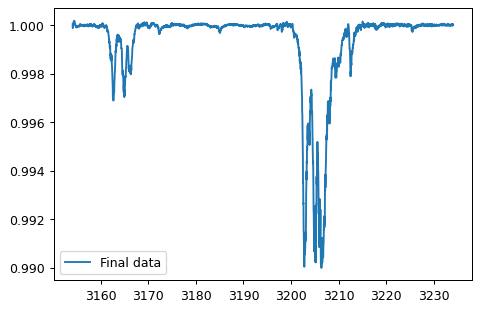

In [5]:
#workup of 2nd column of data, just run this part
#donot run it twice in sequence!!! (run from loading of raw data if you want to run this part again)

data[:, 1] = 1 - 0.01*(dataRaw[:, 1] - CS(data[:, 0]))/(np.max(dataRaw[:, 1]) - CS(data[dataRaw[:, 1] == np.max(dataRaw[:, 1]), 0]))
plt.plot(data[:, 0], data[:, 1], label = 'Final data')
plt.legend()

In [6]:
#run this part to select start and end points of peak (in strict increasing wavelength order)
#select only start and end points of peaks, nothing else
#make sure no. of points selected is two times no. of peaks

CF2 = ContinuumFitter(data[:, 0], data[:, 1])
wvs1 = CF2.SelectPoints(n=100, y_message = 'Select peak start and end points')[:, 0]
peakRanges = np.reshape(wvs1, (int(wvs1.size/2), 2))

In [7]:
#just run this part to check peak ranges

print(peakRanges)

[[3161.01485808 3163.44434533]
 [3164.01430218 3165.57370819]
 [3165.57370819 3167.67337866]
 [3200.12518156 3204.26413492]
 [3204.26413492 3211.46231384]
 [3212.0319694  3214.25160762]]


In [8]:
#calculation of sd here, just run this part

sdArr = data

for it2 in range(peakRanges.shape[0]):
    #print(np.logical_and(sdArr[:, 0] >= peakRanges[it2, 0], sdArr[:, 0] <= peakRanges[it2, 1]).shape)
    sdArr = np.delete(sdArr, np.logical_and(sdArr[:, 0] >= peakRanges[it2, 0], sdArr[:, 0] <= peakRanges[it2, 1]), 0)

sd = np.std(sdArr[:, 1])
print(sd)

8.406874125259017e-05


{'Centre1': 3162.646553416632, 'FWHM1': 0.905081149918081, 'ChiSq1': 409.80957025643056, 'RedChiSq1': 5.1874629146383615, 'Centre2': 3164.930771706752, 'FWHM2': 0.9456024388263198, 'ChiSq2': 141.03036120656665, 'RedChiSq2': 2.820607224131333, 'Centre3': 3166.1747122221, 'FWHM3': 1.0344793753169785, 'ChiSq3': 144.28778164387757, 'RedChiSq3': 2.121879141821729, 'Centre4': 3202.9970891137054, 'FWHM4': 1.3251652783785248, 'ChiSq4': 15273.512162727424, 'RedChiSq4': 112.30523649064283, 'Centre5': 3206.0523109666356, 'FWHM5': 3.54255461733452, 'ChiSq5': 41217.234875031325, 'RedChiSq5': 173.18165913878707, 'Centre6': 3212.6456386591417, 'FWHM6': 0.7170598290930525, 'ChiSq6': 488.03752999978303, 'RedChiSq6': 6.778299027774764}


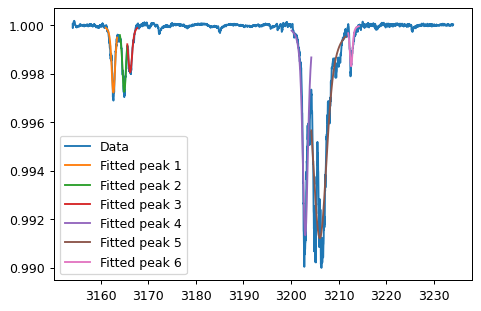

In [11]:
#fitting part, just run this part

plt.plot(data[:, 0], data[:, 1], label = 'Data')
rawParams = voigtNUniPeak(data, peakRanges, sd)
plt.legend()
print(rawParams)

In [13]:
#to load raw parameters into array passable in stacker, change the file name according to molecule and run this part
#if you want to force edit, change fEdit to 1, otherwise keep it to 0

fEdit = 1

params = np.zeros((peakRanges.shape[0], 2))

for it1 in range(peakRanges.shape[0]):
    lab1 = 'Centre' + str(it1+1)
    lab2 = 'FWHM' + str(it1+1)
    params[it1, 0] = rawParams[lab1]
    params[it1, 1] = rawParams[lab2]

print(params)

#change fileName here according to molecule
fileName = 'Lab Spectra Parameters/PyreneParams.txt'

if (not os.path.exists(fileName)) or fEdit == 1:
    np.savetxt(fileName, params)

[[3.16264655e+03 9.05081150e-01]
 [3.16493077e+03 9.45602439e-01]
 [3.16617471e+03 1.03447938e+00]
 [3.20299709e+03 1.32516528e+00]
 [3.20605231e+03 3.54255462e+00]
 [3.21264564e+03 7.17059829e-01]]


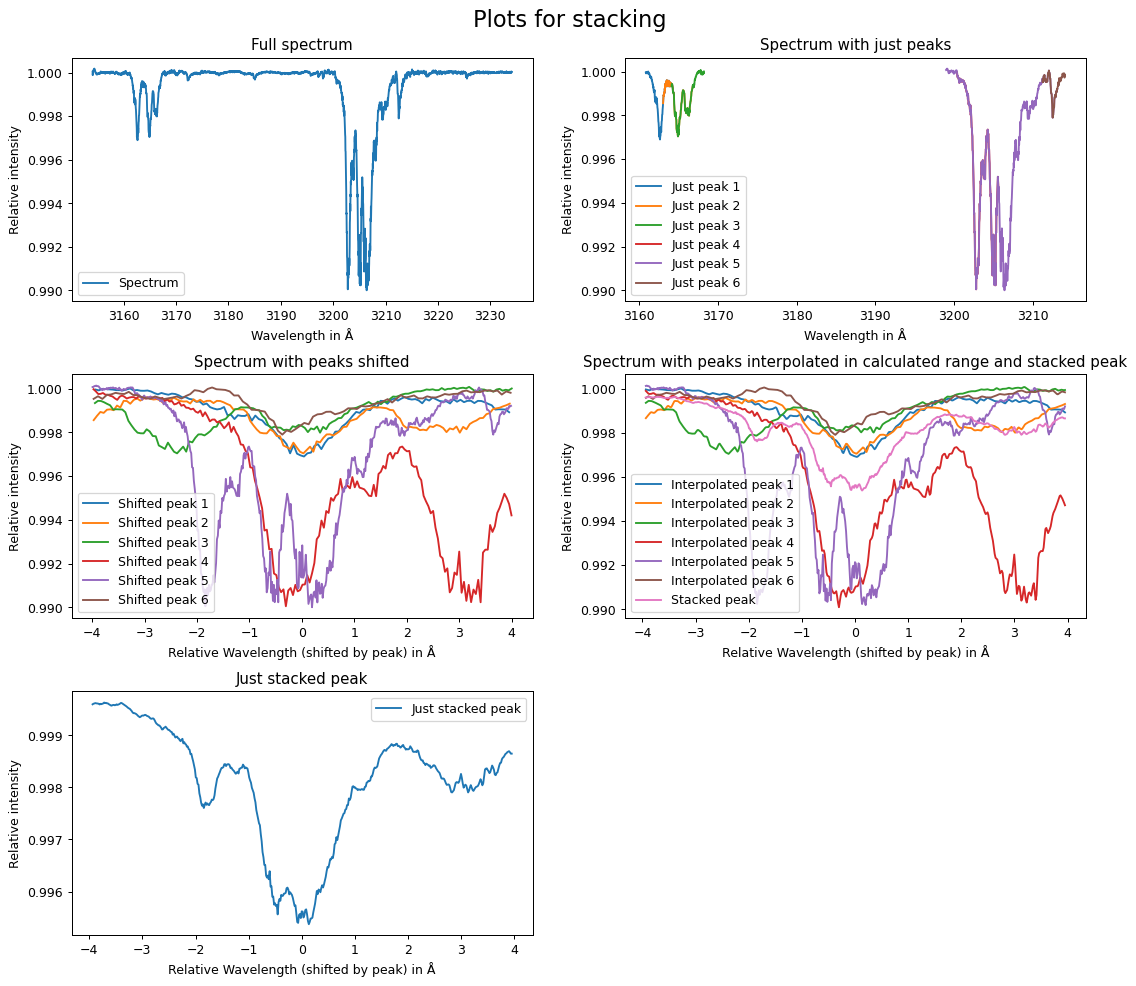

In [14]:
#stacking for checking, just run this part

stackedData = widthNormLinStacker(data, params)